# Assignment

In [20]:
# Import 
import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *

# Define the size of the board
size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [21]:
## INITIALISE THE ENVIRONMENT

env = Chess_Env(size_board)

In [22]:
# Epsilon-Greedy Policy
def EpsilonGreedy_Policy(Qvalues, epsilon, allowed):

    N_allowed = np.shape(allowed)[0]

    Qvalues_of_allowed = Qvalues[allowed]
    
    rand_value = np.random.uniform(0,1)

    rand_a = rand_value < epsilon

    if rand_a == True:

        temp = np.random.randint(0, N_allowed)
        a = allowed[temp]

    else:

        temp = np.argmax(Qvalues_of_allowed)
        a = allowed[temp]
            
    return a

In [23]:
S, X, allowed_a = env.Initialise_game()
N_a = np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in = np.shape(X)[0]    # INPUT SIZE
N_h = 200                # NUMBER OF HIDDEN NODES

# INITALISE YOUR NEURAL NETWORK...

np.random.seed(67)

# Weights and biases
initial_W1 = np.random.randn(N_h, N_in) * 0.01
initial_b1 = np.zeros((N_h,))
initial_W2 = np.random.randn(N_a, N_h) * 0.01
initial_b2 = np.zeros((N_a,))

number_of_reps = 4

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE
lamb = 0
types = ["Q-learning", "SARSA"]

N_episodes = 1000 # THE NUMBER OF GAMES TO BE PLAYED 

avg_N_moves = []
avg_R_save = []

all_N_moves = []
all_R_save = []

# Eligibility traces
eligibility_trace = True
if eligibility_trace:    
    lamb = 0.3
    eta = 0.008
    
for t in range(len(types)):

    for j in range(number_of_reps):
    
        # SAVING VARIABLES
        R_save = np.zeros([N_episodes, 1])
        N_moves_save = np.zeros([N_episodes, 1])
        
        learning_type = types[t] # THE LEARNING TYPE (SARSA OR Q-learning)
        
        W1 = initial_W1
        b1 = initial_b1
        W2 = initial_W2
        b2 = initial_b2

        for n in range(N_episodes):

            epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
            Done = 0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
            i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
            
            S, X, allowed_a = env.Initialise_game()      ## INITIALISE GAME
            print(str(learning_type) + " " + str(n))
            
            # Initialise eligibility traces 
            if eligibility_trace:
                e = np.zeros(N_a,)

            if learning_type == "SARSA":
                h1 = np.matmul(W1, X) + b1
                # Apply the ReLU activation function
                x1 = np.maximum(0, h1)
                # Compute Qvalues
                Qvalues = np.matmul(W2, x1) + b2
                a, _ = np.where(allowed_a == 1)
                a_agent = EpsilonGreedy_Policy(Qvalues, epsilon_f, a)

            while not Done:  ## START THE EPISODE

                # Forward propagation
                h1 = np.matmul(W1, X) + b1
                # Apply the ReLU activation function
                x1 = np.maximum(0, h1)
                # Compute Qvalues
                Qvalues = np.matmul(W2, x1) + b2
                
                if learning_type == "Q-learning":  
                    a, _ = np.where(allowed_a == 1)
                    a_agent = EpsilonGreedy_Policy(Qvalues, epsilon_f, a)

                S_next, X_next, allowed_a_next, R, Done = env.OneStep(a_agent)

                # Update the eligibility trace for the action made
                if eligibility_trace:

                    e[a_agent] = e[a_agent] + 1

                if Done:
                    
                    # Backward propagation
                    delta2 = R - Qvalues[a_agent]
                    
                    eta_delta2 = eta * delta2
                    W2[a_agent] = W2[a_agent] + eta_delta2 * x1
                    b2[a_agent] = b2[a_agent] + eta_delta2
                    
                    # update the weights of the hidden layer
                    delta1 = np.dot(W2[a_agent], delta2) * (x1 > 0)

                    W1 = W1 + eta * np.outer(delta1, X)
                    b1 = b1 + eta * delta1

                    # SAVE THE RESULTS
                    # R_save[n] = np.copy(R)
                    # N_moves_save[n] = np.copy(i)

                    if n == 0:
                        R_save[n] = np.copy(R) * eta
                        N_moves_save[n] = np.copy(i) * eta
                    else:
                        R_save[n] = (1 - eta) * R_save[n - 1] + eta * np.copy(R) 
                        N_moves_save[n] = (1 - eta) * N_moves_save[n - 1] + eta * np.copy(i) 

                    if eligibility_trace:
                        W2 = W2 + eta_delta2 * np.outer(e, x1)

                    break
                
                else:

                    h1 = np.matmul(W1, X_next) + b1
                    
                    # Apply the ReLU activation function
                    x1 = np.maximum(0, h1)

                    # Compute Qvalues
                    Qvalues1 = np.matmul(W2, x1) + b2
                    
                    a1, _ = np.where(allowed_a_next == 1)

                    if learning_type == "SARSA":
                        a1_agent = EpsilonGreedy_Policy(Qvalues1, epsilon_f, a1)
                    else:
                        # Since EpsilonGreedy_Policy retrieves the index of the maximum of the Qvalues, we can use it for Q-learning
                        a1_agent = EpsilonGreedy_Policy(Qvalues1, 0, a)
                        # a1_agent = EpsilonGreedy_Policy(Qvalues, 0, a1)
                        
                    # Backward propagation
                    delta2 = R + gamma * Qvalues1[a1_agent] - Qvalues[a_agent]

                    eta_delta2 = eta * delta2
                    
                    W2[a_agent] = W2[a_agent] + eta_delta2 * x1
                    b2[a_agent] = b2[a_agent] + eta_delta2

                    delta1 = np.dot(W2[a_agent], delta2) * (x1 > 0)

                    W1 = W1 + eta * np.outer(delta1, X)
                    b1 = b1 + eta * delta1

                    if eligibility_trace:
                        W2 = W2 + eta_delta2 * np.outer(e, x1)
                        e = gamma * lamb * e
                    
                # NEXT STATE AND CO. BECOME ACTUAL STATE...
                S = np.copy(S_next)
                X = np.copy(X_next)
                allowed_a = np.copy(allowed_a_next)

                if learning_type == "SARSA":
                    a_agent = np.copy(a1_agent)
                
                i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
        
        avg_N_moves.append(N_moves_save)
        avg_R_save.append(R_save)
    
    merged_array_N_moves = np.mean(avg_N_moves, axis=0)
    merged_array_R_save = np.mean(avg_R_save, axis=0)

    #all_N_moves.append(N_moves_save)
    #all_R_save.append(R_save)    
    all_N_moves.append(np.reshape(merged_array_N_moves, (1, merged_array_N_moves.shape[0])))
    all_R_save.append(np.reshape(merged_array_R_save, (1, merged_array_R_save.shape[0])))

Q-learning 0
Q-learning 1
Q-learning 2
Q-learning 3
Q-learning 4
Q-learning 5
Q-learning 6
Q-learning 7
Q-learning 8
Q-learning 9
Q-learning 10
Q-learning 11
Q-learning 12
Q-learning 13
Q-learning 14
Q-learning 15
Q-learning 16
Q-learning 17
Q-learning 18
Q-learning 19
Q-learning 20
Q-learning 21
Q-learning 22
Q-learning 23
Q-learning 24
Q-learning 25
Q-learning 26
Q-learning 27
Q-learning 28
Q-learning 29
Q-learning 30
Q-learning 31
Q-learning 32
Q-learning 33
Q-learning 34
Q-learning 35
Q-learning 36
Q-learning 37
Q-learning 38
Q-learning 39
Q-learning 40
Q-learning 41
Q-learning 42
Q-learning 43
Q-learning 44
Q-learning 45
Q-learning 46
Q-learning 47
Q-learning 48
Q-learning 49
Q-learning 50
Q-learning 51
Q-learning 52
Q-learning 53
Q-learning 54
Q-learning 55
Q-learning 56
Q-learning 57
Q-learning 58
Q-learning 59
Q-learning 60
Q-learning 61
Q-learning 62
Q-learning 63
Q-learning 64
Q-learning 65
Q-learning 66
Q-learning 67
Q-learning 68
Q-learning 69
Q-learning 70
Q-learning 71
Q-

KeyboardInterrupt: 

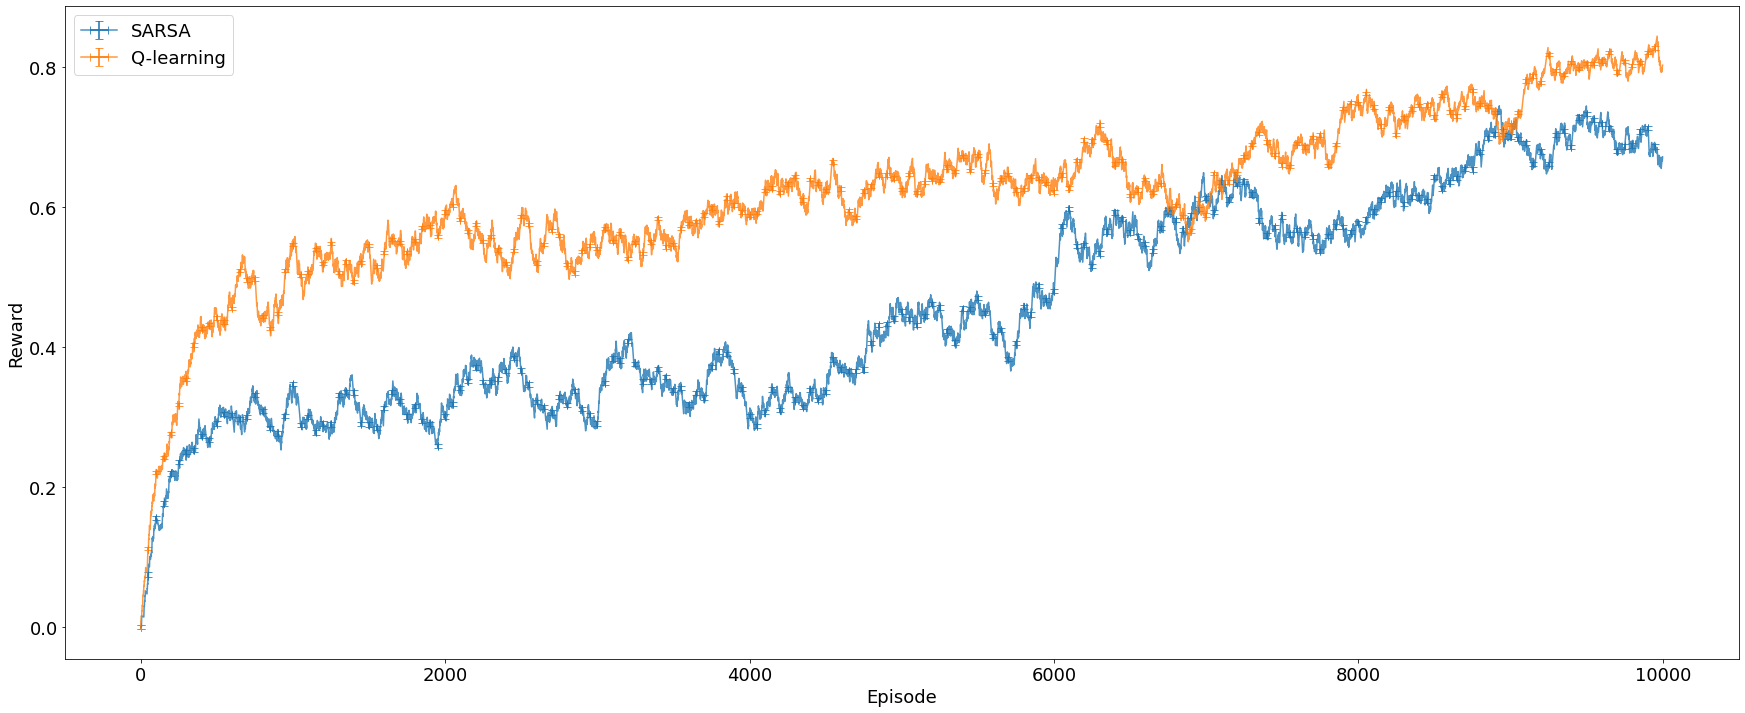

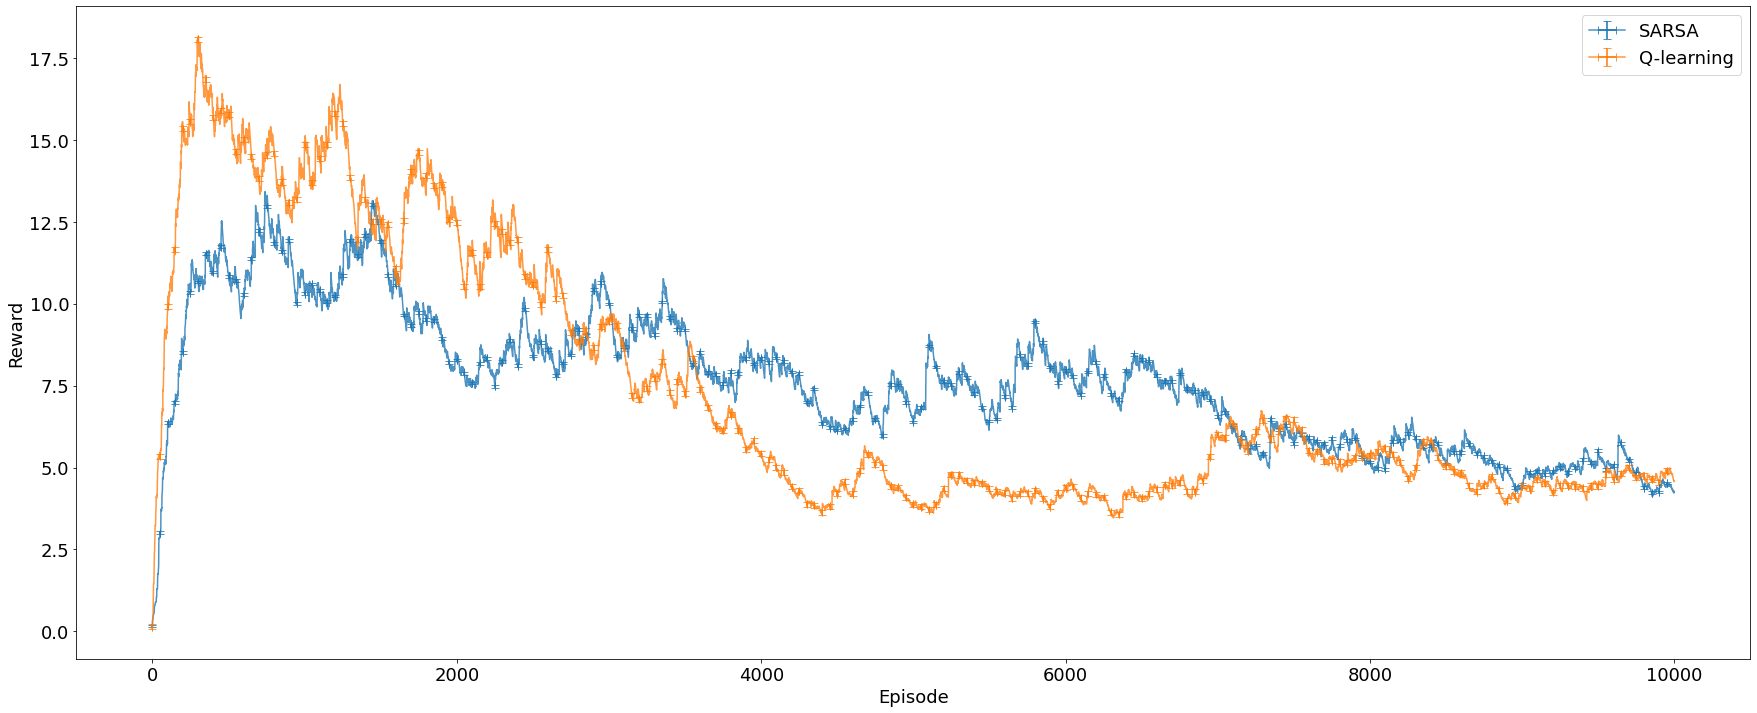

In [ ]:
plt.figure(figsize=(30, 12))
for i, R_save in enumerate(all_R_save):
    errors = 2 * np.std(R_save) / np.sqrt(N_episodes) 
    plt.errorbar(np.arange(N_episodes), R_save.flatten(), errors, 0, elinewidth=2, capsize=4, alpha=0.8, errorevery=50)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.rcParams.update({'font.size': 18})
labels = ["SARSA", "Q-learning"]  # Add more labels if needed
plt.legend(labels)
plt.savefig('EMA_Reward.pdf')

plt.figure(figsize=(30, 12))
for i, N_moves_save in enumerate(all_N_moves):
    errors = 2 * np.std(N_moves_save) / np.sqrt(N_episodes) 
    plt.errorbar(np.arange(N_episodes), N_moves_save.flatten(), errors, 0, elinewidth=2, capsize=4, alpha=0.8, errorevery=50)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.rcParams.update({'font.size': 18})
labels = ["SARSA", "Q-learning"]  # Add more labels if needed
plt.legend(labels)
plt.savefig('EMA_Moves.pdf')